## Checking on freshwater input

Previously, interpolation of freshwaer fluxes into a new grid have yield spuriously low total coastal discharge. This notebook is for checking wether the freshwater input is correct, and if it matches the JRA55do forcing

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import xarray as xr
from dask.distributed import Client
import intake
import cmocean as cm

In [2]:
client = Client(threads_per_worker = 1)

Load datastore

In [3]:
esm_datastore = intake.open_esm_datastore(
    "/g/data/ol01/cy8964/access-om3/archive/8km_jra_ryf_obc_Charrassin/experiment_datastore.json", 
    columns_with_iterables=[
            "variable",
            "variable_long_name",
            "variable_standard_name",
            "variable_cell_methods",
            "variable_units",
    ] # This is important
)

List available diagnostics

Load month 0 specific datastore to get y axis info

In [4]:
mo0_esm_datastore = intake.open_esm_datastore(
    "/g/data/ol01/cy8964/access-om3/datastores/8km_jra_ryf_obc_Charrassin-output000/experiment_datastore.json", 
    columns_with_iterables=[
            "variable",
            "variable_long_name",
            "variable_standard_name",
            "variable_cell_methods",
            "variable_units",
    ] # This is important
)

ds_good_yh = mo0_esm_datastore.search(variable="umo_2d").to_dask(xarray_open_kwargs={'decode_timedelta':True})
good_yh_coords = ds_good_yh.yh.copy().load()
ds_good_yq = mo0_esm_datastore.search(variable="vmo_2d").to_dask(xarray_open_kwargs={'decode_timedelta':True})
good_yq_coords = ds_good_yq.yq.copy().load()
def reset_y_coords(ds): #thanks to Jemma Jeffree for helping make this work!!
    ds = ds.assign_coords({'yh':good_yh_coords})
    ds = ds.assign_coords({'yq':good_yq_coords})
    return ds

When loading data that has a y-axis, you need to use the `preprocess` (and likely `decode_timedelta` too) arguments:
```
esm_datastore.search(variable="").to_dask(preprocess=reset_y_coords,xarray_open_kwargs={'decode_timedelta':True})
```

For example:

## Importing the runoff values


In [5]:
lat_slice = slice(-85,-61)
#iceberg total
panantrom3_total_friver = esm_datastore.search(variable="total_ficeberg").to_dask(preprocess=reset_y_coords,xarray_open_kwargs={'decode_timedelta':True}).total_ficeberg
panantrom3_frunoff = xr.open_dataset('/scratch/x77/cy8964/access-om3/archive/8km_jra_ryf_obc2-sapphirerapid-Charrassin-newparams-rerun-Wright-spinup-accessom2IC-yr9/output122/access-om3.mom6.2d.frunoff.1day.mean.1910.nc').frunoff.isel(time=0)
#panan liquid runoff in kg m-2 s-1
panantrom3_lrunoff = esm_datastore.search(variable="lrunoff", frequency = '1mon').to_dask(preprocess=reset_y_coords,xarray_open_kwargs={'decode_timedelta':True}).sel(yh=lat_slice).lrunoff
panantrom3_lrunoff_mean = panantrom3_lrunoff.mean('time')
#panan surface_area in m2
panantrom3_area = esm_datastore.search(variable="areacello").to_dask(preprocess=reset_y_coords,xarray_open_kwargs={'decode_timedelta':True}).areacello



rho_ref = 1035 #kg/m3

/jobfs/147773012.gadi-pbs/ipykernel_4013836/1662884209.py:4: FutureWarning: In a future version, xarray will not decode timedelta values based on the presence of a timedelta-like units attribute by default. Instead it will rely on the presence of a timedelta64 dtype attribute, which is now xarray's default way of encoding timedelta64 values. To continue decoding timedeltas based on the presence of a timedelta-like units attribute, users will need to explicitly opt-in by passing True or CFTimedeltaCoder(decode_via_units=True) to decode_timedelta. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  panantrom3_frunoff = xr.open_dataset('/scratch/x77/cy8964/access-om3/archive/8km_jra_ryf_obc2-sapphirerapid-Charrassin-newparams-rerun-Wright-spinup-accessom2IC-yr9/output122/access-om3.mom6.2d.frunoff.1day.mean.1910.nc').frunoff.isel(time=0)
/g/data/xp65/public/apps/med_conda/envs/analysis3-25.07/lib/python3.11/site-packages/intake_esm/source.py:2

In [6]:
panantrom3_lrunoff.load()
panantrom3_lrunoff_mean.load()
panantrom3_area.load()
panantrom3_frunoff.load()
print('loaded values to the memory')

loaded values to the memory


In [7]:
panantrom3_trunoff_field = (panantrom3_lrunoff_mean + panantrom3_frunoff)

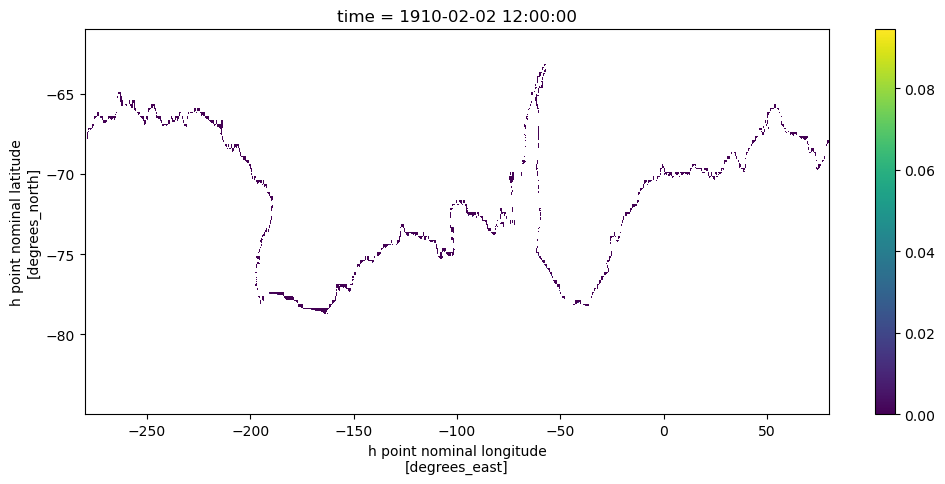

In [8]:
plt.figure(figsize=(12,5))
panantrom3_trunoff_field.where(panantrom3_trunoff_field!=0).plot()

In [9]:
#calculating total FWF
panantrom3_lrunoff_mean_SV = (((panantrom3_trunoff_field* panantrom3_area)/rho_ref)*1e-6).sum().values
icebergs = (panantrom3_total_friver.mean('time')*1e-6/rho_ref).values
#total = panantrom3_lrunoff_mean_SV + icebergs
total = panantrom3_lrunoff_mean_SV
print('Runoff without icebergs = ' + str(np.round(panantrom3_lrunoff_mean_SV,5)) +' Sv \n' +\
     'Runoff with icebergs fluxes = '  + str(np.round(total,5)) +' Sv')

Runoff without icebergs = 0.08451 Sv 
Runoff with icebergs fluxes = 0.08451 Sv


That is a suspiciously low value. let's try the same with panan01, which we know is correct

In [10]:
catalog = intake.cat.access_nri

In [11]:
#panan liquid runoff in kg m-2 s-1
panant01_lrunoff = catalog["panant-01-zstar-ACCESSyr2"].search(variable="lrunoff", frequency = '1mon').to_dask(xarray_open_kwargs={'decode_timedelta':True}).sel(yh=lat_slice).lrunoff
panant01_lrunoff_mean = panant01_lrunoff.mean('time')
#area in m2
panant01_area =catalog["panant-01-zstar-ACCESSyr2"].search(variable="areacello").to_dask(xarray_open_kwargs={'decode_timedelta':True}).sel(yh=lat_slice).areacello



/g/data/xp65/public/apps/med_conda/envs/analysis3-25.07/lib/python3.11/site-packages/intake_esm/core.py:259: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  records = grouped.get_group(internal_key).to_dict(orient='records')
/g/data/xp65/public/apps/med_conda/envs/analysis3-25.07/lib/python3.11/site-packages/intake_esm/core.py:259: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  records = grouped.get_group(internal_key).to_dict(orient='records')
/g/data/xp65/public/apps/med_conda/envs/analysis3-25.07/lib/python3.11/site-packages/intake_esm/source.py:280: ConcatenationWarning: Attempting to concatenate datasets without valid dimension coordinates: retaining only first dataset. Request valid

In [12]:
panant01_lrunoff.load()
panant01_lrunoff_mean.load()
panant01_area.load()
print('loaded values to the memory')

loaded values to the memory


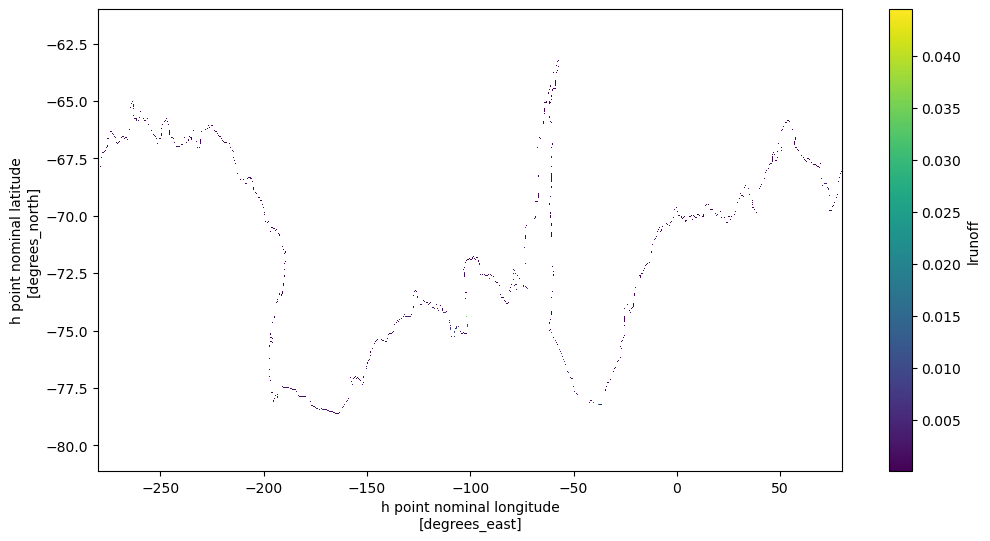

In [13]:
plt.figure(figsize=(12,6))
panant01_lrunoff_mean.where(panant01_lrunoff_mean!=0).plot()

In [14]:
panant01_lrunoff_mean_SV = (((panant01_lrunoff_mean* panant01_area)/rho_ref)*1e-6).sum().values
panant01_lrunoff_mean_SV
print('Runoff in panan01 = ' + str(np.round(panant01_lrunoff_mean_SV,5)) +' Sv')

Runoff in panan01 = 0.08451 Sv


### Summary

Total freshwater input in the simulation is correct, and similar to the value previously assigned of 0.08451 Sv for previous regional Antarctic MOM6 simulations (e.g, Panan01). However, the spatial field is incorrect. This validation will need to be rerun  once the spatial fields of runoff are corrected.

Current Github issues trying to solve the problem:
- [Issue on ACCESS-OM3 configs](https://github.com/ACCESS-NRI/access-om3-configs/issues/727#issue-3336049091)
- [Issue on rOM3 validation](https://github.com/claireyung/mom6-panAn-iceshelf-tools/issues/15#issuecomment-3195298528)